In [34]:
# Load all the libraries needed for running this notebook
library(tidyverse)
library(repr)
library(ggplot2)
options(repr.matrix.max.rows = 4) #limits output of dataframes to 4 rows

 # Questions  


#### Broad Question: 
Question 1: What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?  

  
#### Specific Question:

Can a player's age and total play hours predict whether they subscribes to a game-related newsletter?

---


To answer this specific question, I will only use the `players` dataset as it includes all the variables I need: `Age`, and `played_hours` are my predictor/explanatory variables, and `subscribe` is my response variable.  
  
  I will wrangle players dataset to remove missing values, convert `subscribe` into a factor variable, and standardize the numerical predictors (`Age` and `played_hours`) by centering & scaling. I'll then apply **K-nearest neighbors classification model** to predict players' subscription status: a class with 2 levels of True and False.

# Data Description


## Players Dataset
Run the code below to load players.csv into a tibble named `players`.  

In [35]:
# load the players dataset from GitHub into an R dataframe (tibble). 
players_url <- "https://raw.githubusercontent.com/Aylin-Ab/dsci-100-2025w1-group-27/refs/heads/main/players.csv"
players <- read_csv(players_url)
players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


This dataframe includes a list of all unique players, including data about each player. After loading the dataset, you can see that the `players` tibble consists of **7 variables** (columns) and **196 observations** (rows).  

  Here's what each variable in the dataset means:
  - **`experience`**: player's experience level, with 5 levels (see Table 2.b)
  - **`subscribe`**: whether the player subscribed to a game-related newsletter (TRUE = subscribed, FALSE = didn't subscribe)
  - **`hashedEmail`**: an anonymized version of each player's email address used to link player data across the two datasets
  - **`played_hours`**: total number of hours, across different sessions, the player has spent playing on the server
  - **`name`**: player's chosen display name/alias
  - **`gender`** player's gender, with 7 levels/genders (see Table 2.b)
  - **`Age`**: player's age in years

### **Table 1**
Summarizes each variables' default and suggested data type and whether it's categorical or numerical.

| Variable | Default Data Type | Suggested Data Type | Categorical or Numerical |
| :-------------: | :---------------: | :--------------------:| :-----------------------: |
| experience    | chr (character)    | fct (factor)        |  Categorical             |
| subscribe     | lgl (logical)      | -                |  *Categorical (Logical)  |
| hashedEmail   | chr (character)    | -                 |  Categorical             |
| played_hours  | dbl (double)       | -                   |  Numerical               |
| name          | chr (character)    | -                |   Categorical            |
| gender        | chr (character)    | fct (factor)        |   Categorical            |
| Age           | dbl (double)       | -                |  Numerical               |

### **Table 2**
a) Summary Statistics for numerical variables in players.csv (2 decimal places).

|Variable    | Mean | Standard Deviation| Min    | Max    | #Missing |
|:----------:|:----:|:----------------: |:------:|:-----: |:--------:|
|played_hours| 5.85 |28.36              | 0      | 223.10 | 0        |
|Age         | 21.14| 7.39              | 9.00   | 58.00  |2         |

B) Summary Statistics for categorical variables in players.csv.

|Variable|#levels (if fct variable)|Level Names| #Missing| Total Count|
|:------:|:-----:|:---------:|:------:|:----:|
|experience|5|Pro, Veteran, Amateur, Regular, Beginner| 0|196|
|subscribe |2|TRUE, FALSE| 0|196|
|hashed_email| n/a|n/a|0|196|
|name| n/a|n/a| 0|196|
|gender| 7 |Male, Female, Non-binary, Prefer not to say, Agender, Two-Spirited, Other| 0|196|

In [36]:
# run this code block to view how each summary statistic in Table 2.a & Table 2.b were calculated.
summary(players)

# summary stats for the numerical variable `played_hours`.
players |> summarise(mean_hours  = mean(played_hours, na.rm = TRUE),
    sd_hours     = sd(played_hours, na.rm = TRUE),
    min_hours    = min(played_hours, na.rm = TRUE),
    max_hours    = max(played_hours, na.rm = TRUE),
    n_missing    = sum(is.na(played_hours)))

# summary stats for the numerical variable `Age`.
players |> summarise(mean_Age  = mean(Age, na.rm = TRUE),
    sd_Age     = sd(Age, na.rm = TRUE),
    min_Age    = min(Age, na.rm = TRUE),
    max_Age    = max(Age, na.rm = TRUE),
    n_missing    = sum(is.na(Age)))


# extract the experience column and find all unique experience levels
experience_levels <- players |>
    pull(experience) |>
    unique()
experience_levels

# extract the gender column and find all unique gender levels
gender_levels <- players |>
    pull(gender) |>
    unique()
gender_levels

# number of observations with missing values for each categorical variable
players |>
    summarize(experience_missing = sum(is.na(experience)),
              subscribe_missing = sum(is.na(subscribe)),
              email_missing = sum(is.na(hashedEmail)),
              name_missing = sum(is.na(name)),
              gender_missing = sum(is.na(gender)))

  experience        subscribe       hashedEmail         played_hours    
 Length:196         Mode :logical   Length:196         Min.   :  0.000  
 Class :character   FALSE:52        Class :character   1st Qu.:  0.000  
 Mode  :character   TRUE :144       Mode  :character   Median :  0.100  
                                                       Mean   :  5.846  
                                                       3rd Qu.:  0.600  
                                                       Max.   :223.100  
                                                                        
     name              gender               Age       
 Length:196         Length:196         Min.   : 9.00  
 Class :character   Class :character   1st Qu.:17.00  
 Mode  :character   Mode  :character   Median :19.00  
                                       Mean   :21.14  
                                       3rd Qu.:22.75  
                                       Max.   :58.00  
                               

mean_hours,sd_hours,min_hours,max_hours,n_missing
<dbl>,<dbl>,<dbl>,<dbl>,<int>
5.845918,28.35734,0,223.1,0


mean_Age,sd_Age,min_Age,max_Age,n_missing
<dbl>,<dbl>,<dbl>,<dbl>,<int>
21.13918,7.389687,9,58,2


[1] "Pro"      "Veteran"  "Amateur"  "Regular"  "Beginner"

[1] "Male"              "Female"            "Non-binary"       
[4] "Prefer not to say" "Agender"           "Two-Spirited"     
[7] "Other"

experience_missing,subscribe_missing,email_missing,name_missing,gender_missing
<int>,<int>,<int>,<int>,<int>
0,0,0,0,0


### Issues of Players Dataset

**1. Data Formatting & Structure**
   - Column names don't follow a consistent naming format.
   - `experience` and `gender` are stored as *character* by default, but it's better to treat them as **factors** since they have few distinct levels.
   - Having 2 dp for `played_hours` would improve accuracy and make variations in data more visible. 

**2. Missing or Ambiguous Variable Values**
   - `gender` includes  "Prefer not to say" and "Other"; should be excluded from analysis if gender is a variable of interest.
   - Two observations have "N/A" values for `Age`; should be excluded if `Age` is a variable of interest.
   - Unclear how `played_hours` was tracked/calculated.
       - If `played_hours` comes from total session times, the rounding is unclear and values don’t match combined session hours in `sessions` dataset (run code below to see why).

**3. Methodological/Conceptual Issues**
   - Meaning and ordering of `experience` levels are unclear. This is a methodological flaw if participants weren't given clear definitions.


In [37]:
# run this code block to see why calculation of played_hours is unclear/inconsistent. 

sessions_url <- "https://raw.githubusercontent.com/Aylin-Ab/dsci-100-2025w1-group-27/refs/heads/main/sessions.csv"
sessions <- read_csv(sessions_url) # to load the sessions.csv

# choose a random email identifier (i.e., player) with small hours_played to simplify calculations
player1 <- sessions |>
    filter(hashedEmail == "8eae13e0f5823d9c48fe7b89695ea231f96f644f664bcc74c5a07f7d0a1135bd") |>
    left_join(players)
player1 

# As you can see in the tibble below, this player has only 1 play session, from 14:01 to 14:35 on 02/05/2024.

# calculate the duration of the play session in hours
start_time_mins <- (14 * 60 + 1)
end_time_mins <- (14 * 60 + 35)

duration_hours <- (end_time_mins - start_time_mins) / 60 
duration_hours 

# output played_hours from player1
played_hours <- player1 |>
    select(played_hours) |>
    pull()

played_hours

# duration_hours and played_hours should be identical if researchers calculated played_hours by combining total session durations for each player.
# However, if we round 0.56 to 1 dp, we get 0.6, not 0.5. 
# You can try the same procedure with other players and see the inconsistency/unclarity of calculated playe_hours.
duration_hours == played_hours

Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(hashedEmail)`


hashedEmail,start_time,end_time,original_start_time,original_end_time,experience,subscribe,played_hours,name,gender,Age
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<lgl>,<dbl>,<chr>,<chr>,<dbl>
8eae13e0f5823d9c48fe7b89695ea231f96f644f664bcc74c5a07f7d0a1135bd,02/05/2024 14:01,02/05/2024 14:35,1.71466e+12,1.71466e+12,Pro,TRUE,0.5,Gray,Male,12


[1] 0.5666667

[1] 0.5

[1] FALSE

## Sessions Dataset
Run the code below to load sessions.csv into a tibble named `sessions`. 

In [38]:
# load the sessions dataset from GitHub into an R dataframe (tibble). 
sessions_url <- "https://raw.githubusercontent.com/Aylin-Ab/dsci-100-2025w1-group-27/refs/heads/main/sessions.csv"
sessions <- read_csv(sessions_url)
sessions

Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,25/07/2024 06:15,25/07/2024 06:22,1.72189e+12,1.72189e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,20/05/2024 02:26,20/05/2024 02:45,1.71617e+12,1.71617e+12


This dataframe includes a list of all individual play sessions by each player, including data about each session. It consists of **5 variables** (columns) and **1535 observations** (rows).
  
Here's what each variable in the dataset means:
- **`hashedEmail`**: an anonymized version of each player's email address used to link player data across the two datasets
- **`start_time`**: start timestamp of each play session, including the date and time (h:m)
- **`end_time`**: end timestamp of each play session, including the date and time (h:m)
- **`original_start_time`**: represent the same values as in `start_time`, but recorded in UNIX time (milliseconds)
- **`original_end_time`**: represent the same values as in `end_time`, but recorded in UNIX time (milliseconds)

### **Table 3**
Summarizes each variables' default and suggested data type and whether it's categorical or numerical.

| Variable Name  | Data Type      | Categorical vs Numerical | 
| -------------       | ---------------    | ---------------     | 
| hashedEmail         | chr (character)    |  Categorical             |
| start_time          | chr (character)    |  Categorical             |
| end_time            | chr (character)    |  Categorical             |
| original_start_time   | dbl (double)       |   Numerical              |
| original_end_time      | dbl (double)       |  Numerical               |

### **Table 4**
a) Summary Statistics for numerical variables in sessions.csv (2 decimal places, in miliseconds).

|Variable    | Mean | Standard Deviation| Min    | Max    | #Missing |
|:----------:|:----:|:----------: |:------:|:-----: |:--------:|
|original_start_time|$1.72 \times 10^{12}$ | 3557491589 | $1.71 \times 10^{12}$  | $1.73 \times 10^{12}$ | 0        |
|original_end_time  | $1.72 \times 10^{12}$| 3552813134 | $1.71 \times 10^{12}$ | $1.73 \times 10^{12}$  |2         |

B) Summary Statistics for categorical variables in players.csv.   

|Variable|#Missing|Total Count|
|:------:|:------:|:---------:|
|hashedEmail|0|1535|
|start_time|0|1535|
|end_time|2|1535|

In [39]:
# run this code block to view how each summary statistic in Table 4.a & Table 4.b were calculated.
summary(sessions)

# summary stats for the numerical variable `original_start_time`.
sessions |> summarise(mean_org_start  = mean(original_start_time, na.rm = TRUE),
        sd_org_start     = sd(original_start_time, na.rm = TRUE),
        min_org_start    = min(original_start_time, na.rm = TRUE),
        max_org_start    = max(original_start_time, na.rm = TRUE),
        n_missing        = sum(is.na(original_start_time))) 

# summary stats for the numerical variable `original_end_time`.
sessions |> summarise(mean_org_end  = mean(original_end_time, na.rm = TRUE),
    sd_org_end      = sd(original_end_time, na.rm = TRUE),
    min_org_end     = min(original_end_time, na.rm = TRUE),
    max_org_end     = max(original_end_time, na.rm = TRUE),
    n_missing       = sum(is.na(original_end_time)))

# number of observations with missing values for each categorical variable
sessions |>
    summarize(email_missing = sum(is.na(hashedEmail)),
              start_missing = sum(is.na(start_time)),
              end_missing = sum(is.na(end_time)))

 hashedEmail         start_time          end_time         original_start_time
 Length:1535        Length:1535        Length:1535        Min.   :1.712e+12  
 Class :character   Class :character   Class :character   1st Qu.:1.716e+12  
 Mode  :character   Mode  :character   Mode  :character   Median :1.719e+12  
                                                          Mean   :1.719e+12  
                                                          3rd Qu.:1.722e+12  
                                                          Max.   :1.727e+12  
                                                                             
 original_end_time  
 Min.   :1.712e+12  
 1st Qu.:1.716e+12  
 Median :1.719e+12  
 Mean   :1.719e+12  
 3rd Qu.:1.722e+12  
 Max.   :1.727e+12  
 NA's   :2          

mean_org_start,sd_org_start,min_org_start,max_org_start,n_missing
<dbl>,<dbl>,<dbl>,<dbl>,<int>
1.719201e+12,3557491589,1.7124e+12,1.72733e+12,0


mean_org_end,sd_org_end,min_org_end,max_org_end,n_missing
<dbl>,<dbl>,<dbl>,<dbl>,<int>
1.719196e+12,3552813134,1.7124e+12,1.72734e+12,2


email_missing,start_missing,end_missing
<int>,<int>,<int>
0,0,2


### Issues of Sessions Dataset
**1. Data Formatting & Structure Issues**
   - Some observations have identical values of `original_start_time` and `original_end_time` (data-collection error or interrupted sessions?)
   - `start_time` and `end_time` combine date and time info in a single column. For a tidier data, each should be separated into two columns (e.g., `start_date` & `start_timestamp`).

**2. Missing Values**  
- Two observations have missing values for `end_time` and `original_end_time`.

# Exploratory Data Analysis and Visualization

As I only need `players` dataset for my research question, the minimal wrangling includes:
- Converting `experience`, `gender`, and `subscribe` into factor variables to be able to group data for data analysis and visualization.

In [40]:
# convert experience and gender columns into factor variables
players <- players |>
    mutate(experience = as.factor(experience)) |>
    mutate(gender = as.factor(gender))


#  convert subscribe column into a factor (TRUE = Subscribed, FALSE = Not Subscribe)
players <- players |>
    mutate(subscribe = as.factor(subscribe)) |>
    mutate(subscribe = factor(subscribe, levels = c(TRUE, FALSE), labels = c("Subscribed", "Not Subscribed")))

players

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<fct>,<fct>,<chr>,<dbl>,<chr>,<fct>,<dbl>
Pro,Subscribed,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,Subscribed,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,Not Subscribed,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,Subscribed,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


### 1. How many players subscribed to the game-related newsletter?

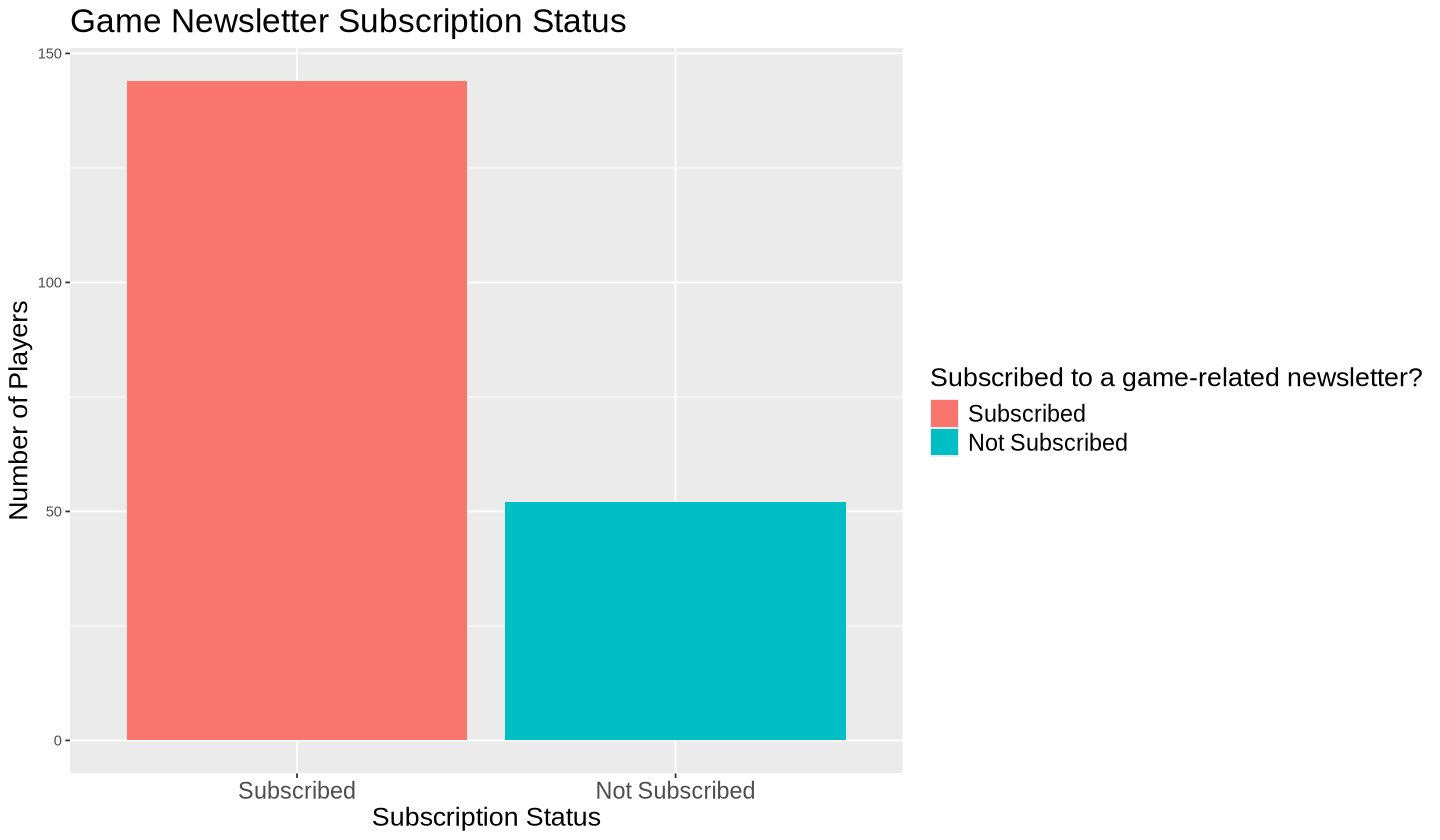

In [57]:
# graph a bar plot to show the distribution of players' subscription status
options(repr.plot.width = 12, repr.plot.height = 7)

subscribe_plot <- players |>
    ggplot(aes(x = subscribe, fill = subscribe)) +
    geom_bar() +
    labs(x = "Subscription Status", y = "Number of Players", fill = "Subscribed to a game-related newsletter?") +
    ggtitle("Game Newsletter Subscription Status") +
    theme(plot.title = element_text(size = 20),
          axis.title.x = element_text(size = 16), 
          axis.title.y = element_text(size = 16),
          axis.text.x = element_text(size = 14),
          legend.title = element_text(size = 16),
          legend.text = element_text(size = 14))

subscribe_plot

Most players in the dataset (~ 140) subscribed to the game-related newsletter, which is more than twice the number of non-subscribers (~ 50). This imbalance means the subscription variable (our outcome variable) is not evenly distributed, which may make it harder for the model to accurately learn patterns for the smaller non-subscriber group. The uneven class proportions can also create challenges during data splitting and cross-validation, as KNN models may become biased toward predicting the majority class.

### 2. What is the distribution of players' age in this dataset?

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


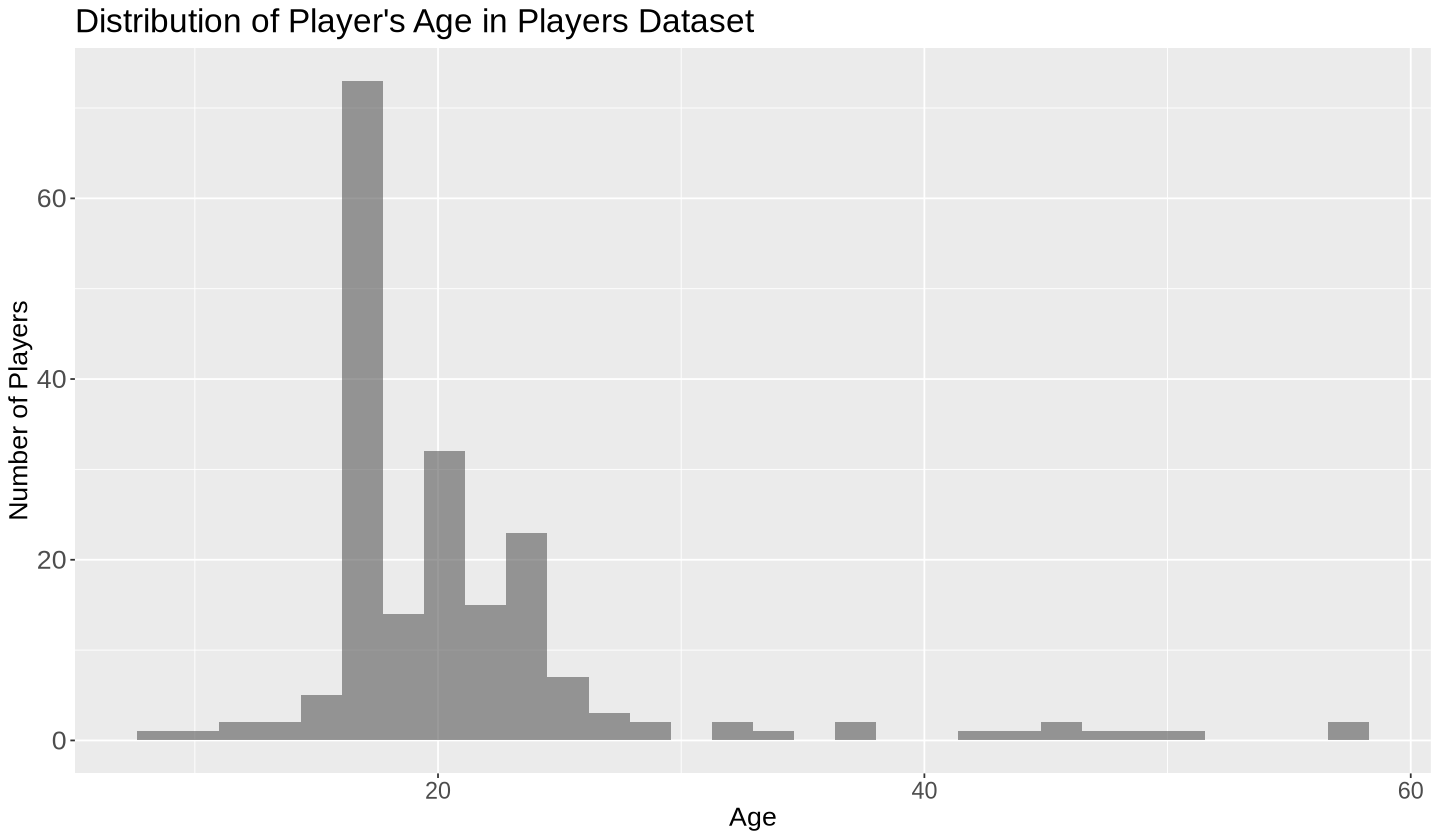

In [60]:
# plot a hitogram to show the distribution of players' age
age_distr <- players |>
    ggplot(aes(x = Age)) +
    geom_histogram(alpha = 0.6) +
    labs(x = "Age", y = "Number of Players") +
    ggtitle("Distribution of Player's Age in Players Dataset") +
    theme(plot.title = element_text(size = 20),
          axis.title.x = element_text(size = 16), 
          axis.title.y = element_text(size = 16),
          axis.text.y = element_text(size = 16),
          axis.text.x = element_text(size = 14))


age_distr

As the above plot shows, the age distribution is strongly right-skewed, with most players clustering between the ages of 15 and 25, with a small number of players between 30 and 60. 

This suggests that age may have limited predictive power for newsletter subscription, since the model will be mainly influenced by the behavior of younger players and won’t have enough data to clearly train and therefore correctly predict how older players might respond in terms of subscription.

### 3. What is the distribution of total played hours in this dataset?

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 85 rows containing non-finite outside the scale range (`stat_bin()`).”


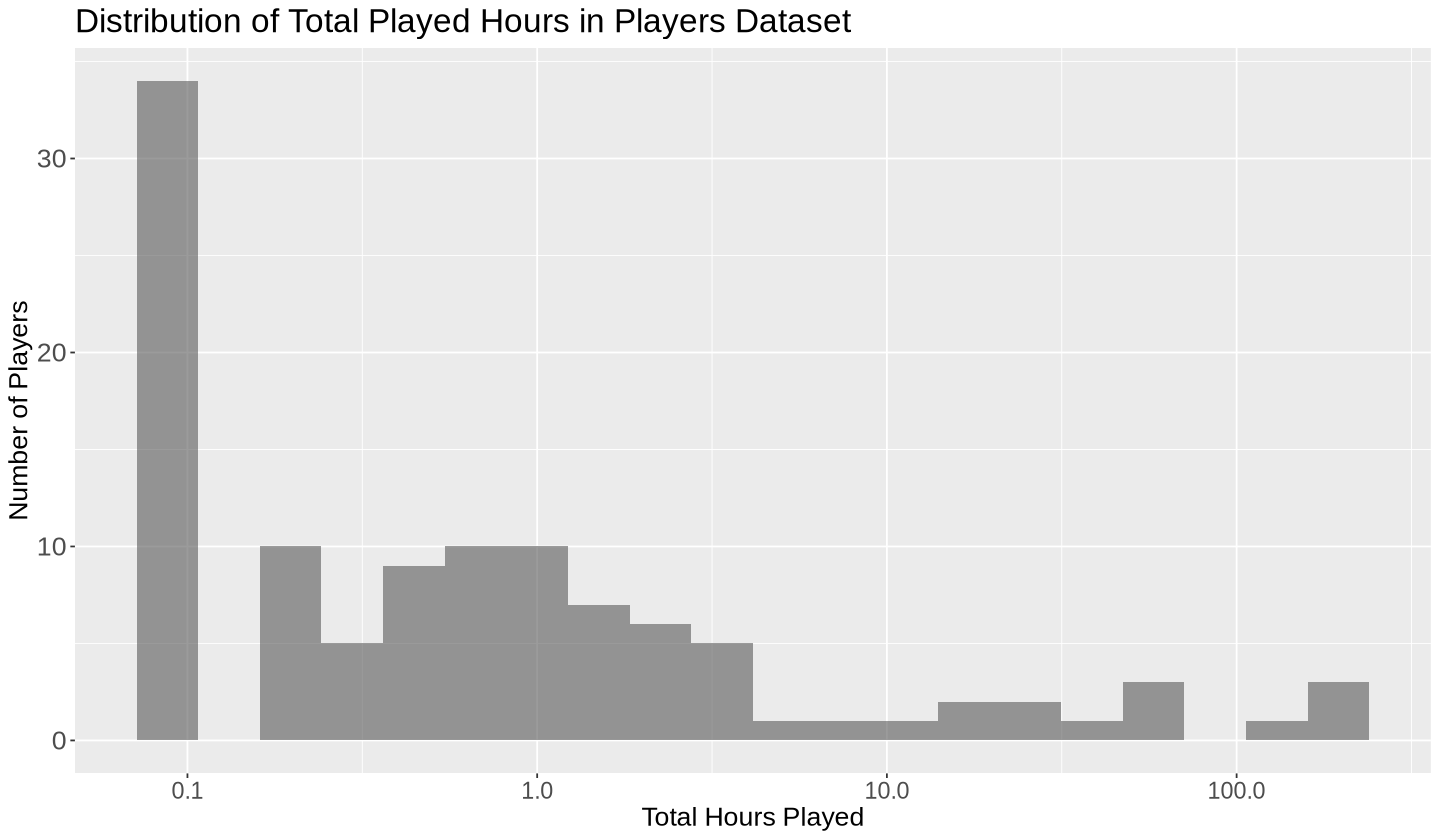

In [61]:
# plot a hitogram to show the distribution of players' total played hours
played_h_distr <- players |>
    ggplot(aes(x = played_hours)) +
    geom_histogram(bins = 20, alpha = 0.6) +
    scale_x_log10() + # use log10 scaling to handle the strong right-skew and make the plot more readable
    labs(x = "Total Hours Played", y = "Number of Players") +
    ggtitle("Distribution of Total Played Hours in Players Dataset") +
    theme(plot.title = element_text(size = 20),
          axis.title.x = element_text(size = 16), 
          axis.title.y = element_text(size = 16),
          axis.text.y = element_text(size = 16),
          axis.text.x = element_text(size = 14))

played_h_distr

Most players have very low total playtime (between 0 and 10 hours), while only a few exceed 100 hours. This strong right-skewness means the model will primarily learn from low-hour players, with very limited info about high-hour players. Therefore, it might struggle to predict subscription status for those with higher playtime due to insufficient data.

### 4. Is there a relationship between players' age and total played hourse?

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


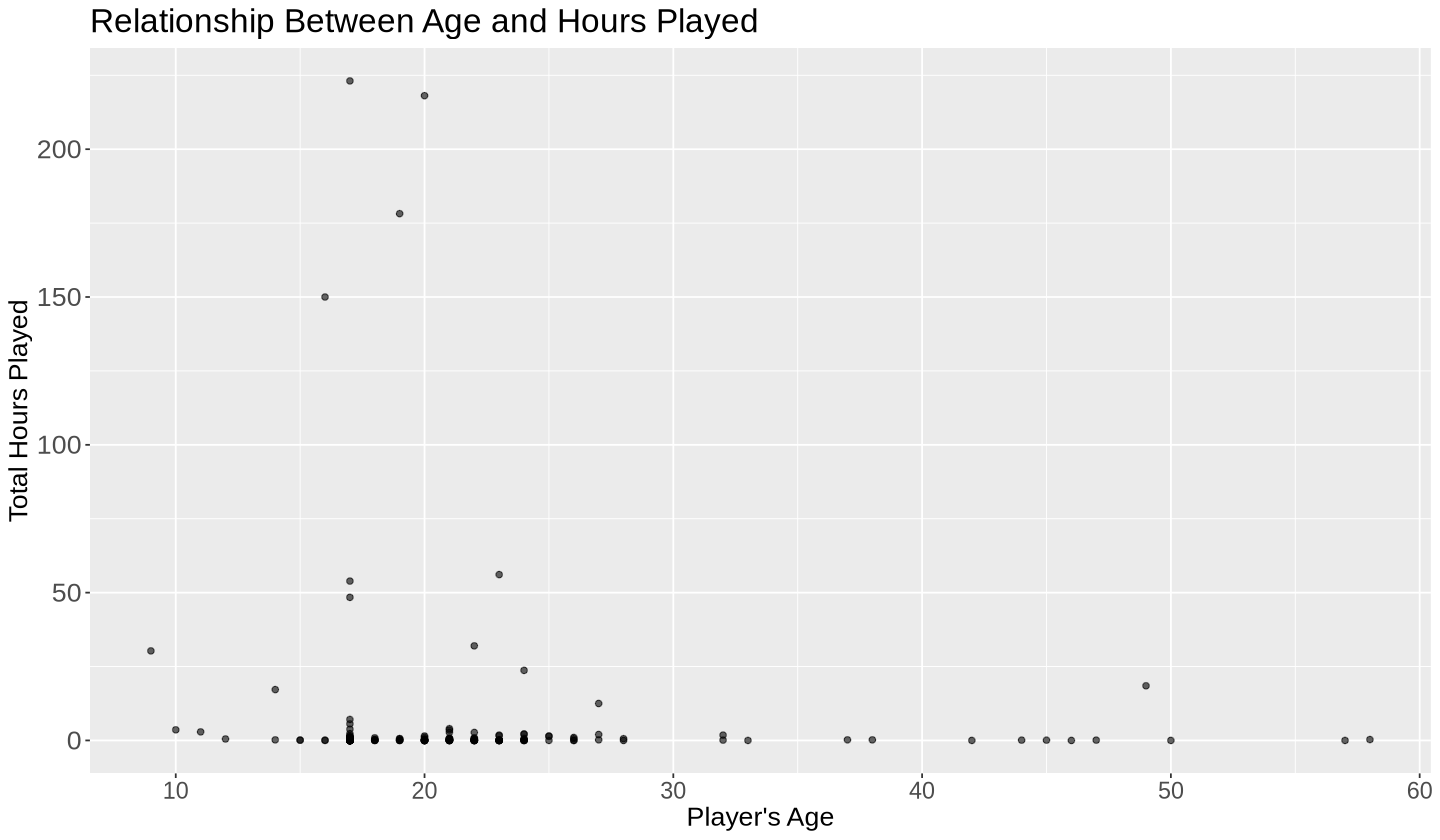

In [62]:
# Create a scatter plot to show the relationship between age and played hours
options(repr.plot.width = 12)
age_vs_hours <- players |>
    ggplot(aes(x = Age, y = played_hours)) +
    geom_point(alpha = 0.6) +
    labs(x = "Player's Age", y = "Total Hours Played") +
    ggtitle("Relationship Between Age and Hours Played") +
    theme(plot.title = element_text(size = 20),
          axis.title.x = element_text(size = 16), 
          axis.title.y = element_text(size = 16),
          axis.text.y = element_text(size = 16),
          axis.text.x = element_text(size = 14))

age_vs_hours

There's no clear relationship between age and total hours played, as the points are widely scattered.

# Methods and Plan